In [4]:
import os
import gc
import time
import shutil
import random
import warnings
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from tqdm import tqdm
import yaml
from joblib import delayed, Parallel

import cv2
import librosa
import audioread
import soundfile as sf

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
#import resnest.torch as resnest_torch

from dataset import SpectrogramDataset



ROOT = Path.cwd()
INPUT_ROOT = ROOT / "../machine_sound"#ROOT / "data/wav_data"


tmp_list = []
for decibel_value in INPUT_ROOT.iterdir():
    for machine in decibel_value.iterdir():
        if machine.is_file():
            continue
        machine_type = machine.stem
        print(f"Reading files in {machine_type} machine type")
        for id in machine.iterdir():
            if id.is_file():
                continue
            id_type = id.stem
            print(f"Reading files in {id_type}")
            for operation in id.iterdir():
                if operation.is_file():
                    continue
                operation_type = operation.stem
                assert operation_type in ["normal", "abnormal"], "Expected normal or abnormal"
                for wav_f in operation.iterdir():
                    if wav_f.is_file() and wav_f.suffix == ".wav":
                        tmp_list.append( [machine_type, id_type, operation_type,
                                          wav_f.name, wav_f.as_posix()])

train_all = pd.DataFrame(
    tmp_list, columns=["machine_type", "id_type", "operation_type",
                        "wav_filename", "wav_file_path"])

print(train_all.sample(5))
print('All df shape ', train_all.shape)

train_df, val_df = train_test_split(train_all, test_size=0.2, random_state=1213)

print('Train df shape ', train_df.shape)
print('Test df shape ', val_df.shape)


def get_loaders_for_training(args_dataset: tp.Dict, args_loader: tp.Dict, \
                             train_file_list: tp.List[str], val_file_list: tp.List[str]):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])

    return train_loader, val_loader, train_dataset, val_dataset


train_file_list = train_df[["wav_file_path", "machine_type"]].values.tolist()
val_file_list = val_df[["wav_file_path", "machine_type"]].values.tolist()

print("train: {}, val: {}".format(len(train_file_list), len(val_file_list)))

with open("./test_config.yaml") as settings_str:
    settings = yaml.safe_load(settings_str)

# for k, v in settings.items():
#     print("[{}]".format(k))
#     print(v)

# # # get loader
train_loader, val_loader, train_dataset, val_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)


# # for batch_idx, (data, target) in enumerate(train_loader):
# #     #data, target = data.to(device), target.to(device)
# #     print(data, target)
# train_iter = iter(train_loader)
# data, target = train_iter.next()
# print(data,target)
# print("END")



Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in .ipynb_checkpoints machine type
Reading files in abnormal machine type
Reading files in .ipynb_checkpoints
Reading files in normal machine type
Reading files in slider machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in slider machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in fan machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in fan machine type
Reading files in id_04
Reading files in 

In [4]:
for ctr, (data, target) in enumerate(train_loader):
    print(target)

In [3]:
data, target = train_dataset.__getitem__(3)
print(data.shape)
print(train_dataset.file_list[3])

(8, 64, 313, 3)
['/home/ubuntu/anudeep/machine_sound_classification/data/wav_data/0_dB_pump/pump/id_00/normal/00000000.wav', 'pump']


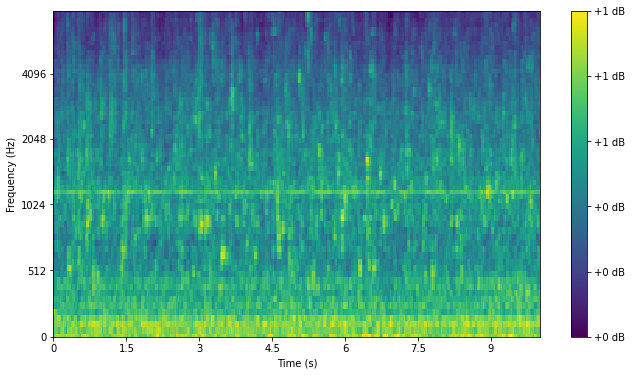

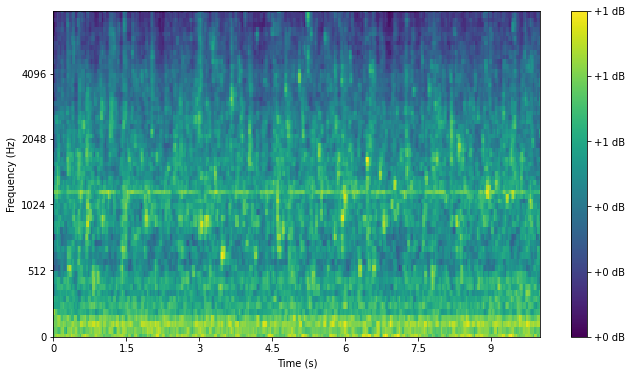

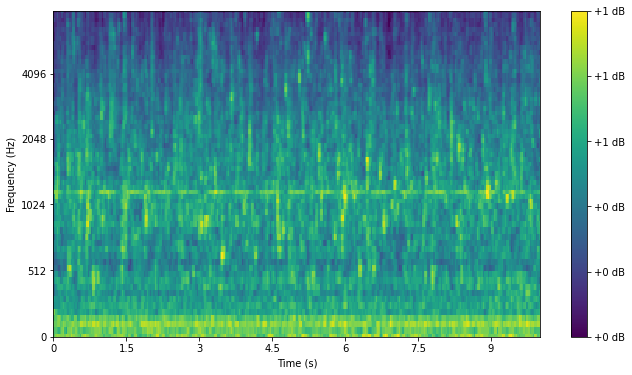

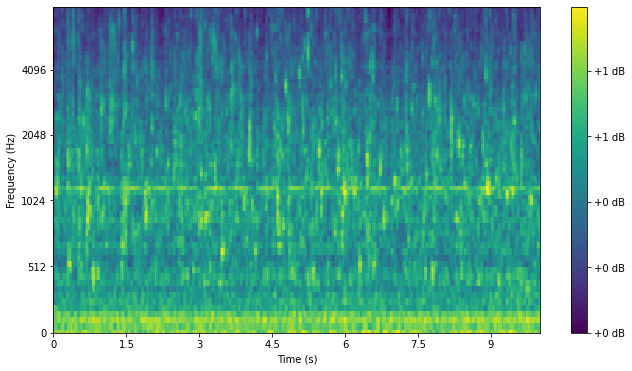

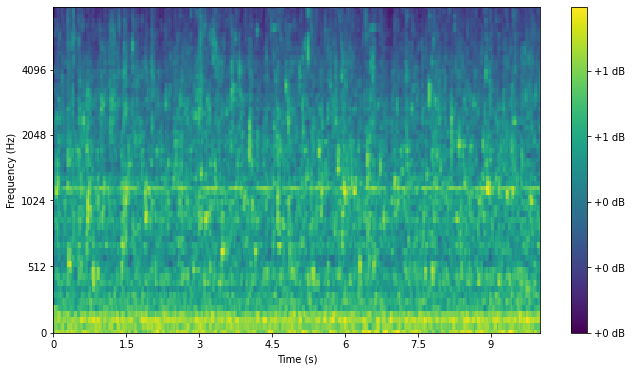

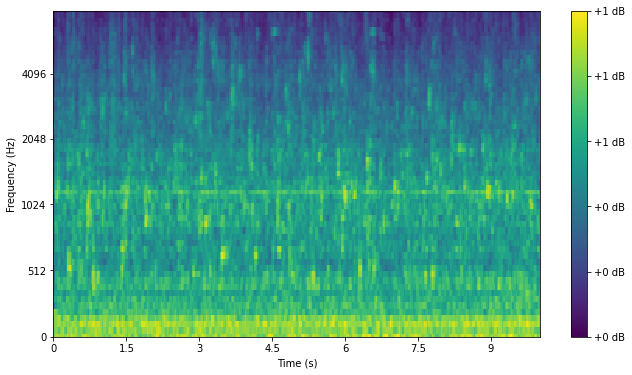

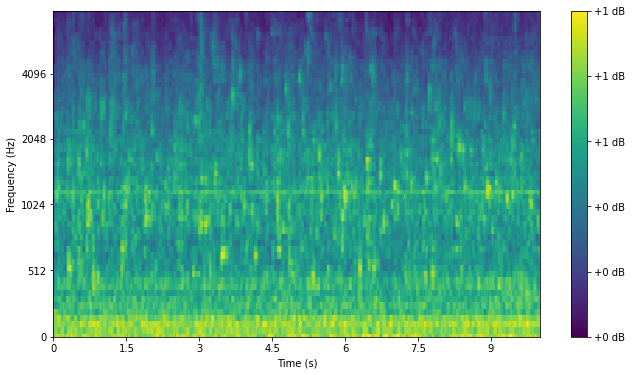

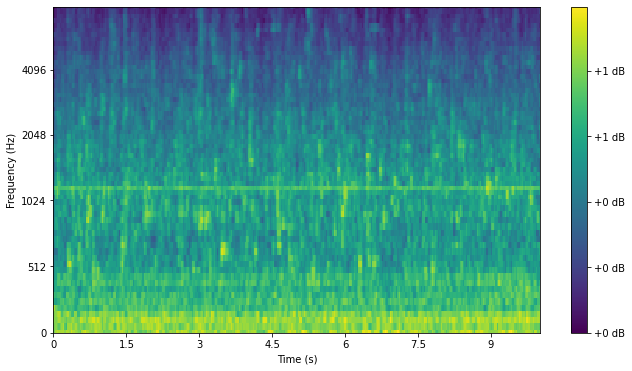

In [5]:
import matplotlib.pyplot as plt
import librosa.display

for k in range(8):
    fig = plt.figure(figsize=(24, 6))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(data[k,:,:,0], sr=16000, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')

In [34]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
MACHINE_CODE = {
    'pump': 0, 'valve': 1, 'slider': 2, 'fan': 3
}

classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

In [43]:
embeddings = []
labels = []
for k in range(0,len(train_all['wav_file_path'])):
    print(k, end="\r", flush=True)
    signal, fs =torchaudio.load(train_all['wav_file_path'][k])
    embeddings.append(classifier.encode_batch(signal[0]).numpy())
    labels.append(MACHINE_CODE[train_all['machine_type'][k]])

In [44]:
embeddings = np.squeeze(np.squeeze(np.array(embeddings), axis=1), axis=1)
labels = np.array(labels)
embeddings.shape, labels.shape

((54057, 512), (54057,))

In [53]:
embeddings.shape, labels.shape

((54057, 512), (54057,))

# PCA and T-SNE

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn


tsne = TSNE(random_state=0, verbose=1)
tsne_results = tsne.fit_transform(embeddings)

tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_results['label'] = labels

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 54057 samples in 0.026s...
[t-SNE] Computed neighbors for 54057 samples in 93.842s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54057
[t-SNE] Computed conditional probabilities for sample 2000 / 54057
[t-SNE] Computed conditional probabilities for sample 3000 / 54057
[t-SNE] Computed conditional probabilities for sample 4000 / 54057
[t-SNE] Computed conditional probabilities for sample 5000 / 54057
[t-SNE] Computed conditional probabilities for sample 6000 / 54057
[t-SNE] Computed conditional probabilities for sample 7000 / 54057
[t-SNE] Computed conditional probabilities for sample 8000 / 54057
[t-SNE] Computed conditional probabilities for sample 9000 / 54057
[t-SNE] Computed conditional probabilities for sample 10000 / 54057
[t-SNE] Computed conditional probabilities for sample 11000 / 54057
[t-SNE] Computed conditional probabilities for sample 12000 / 54057
[t-SNE] Computed conditional probabilities for sa

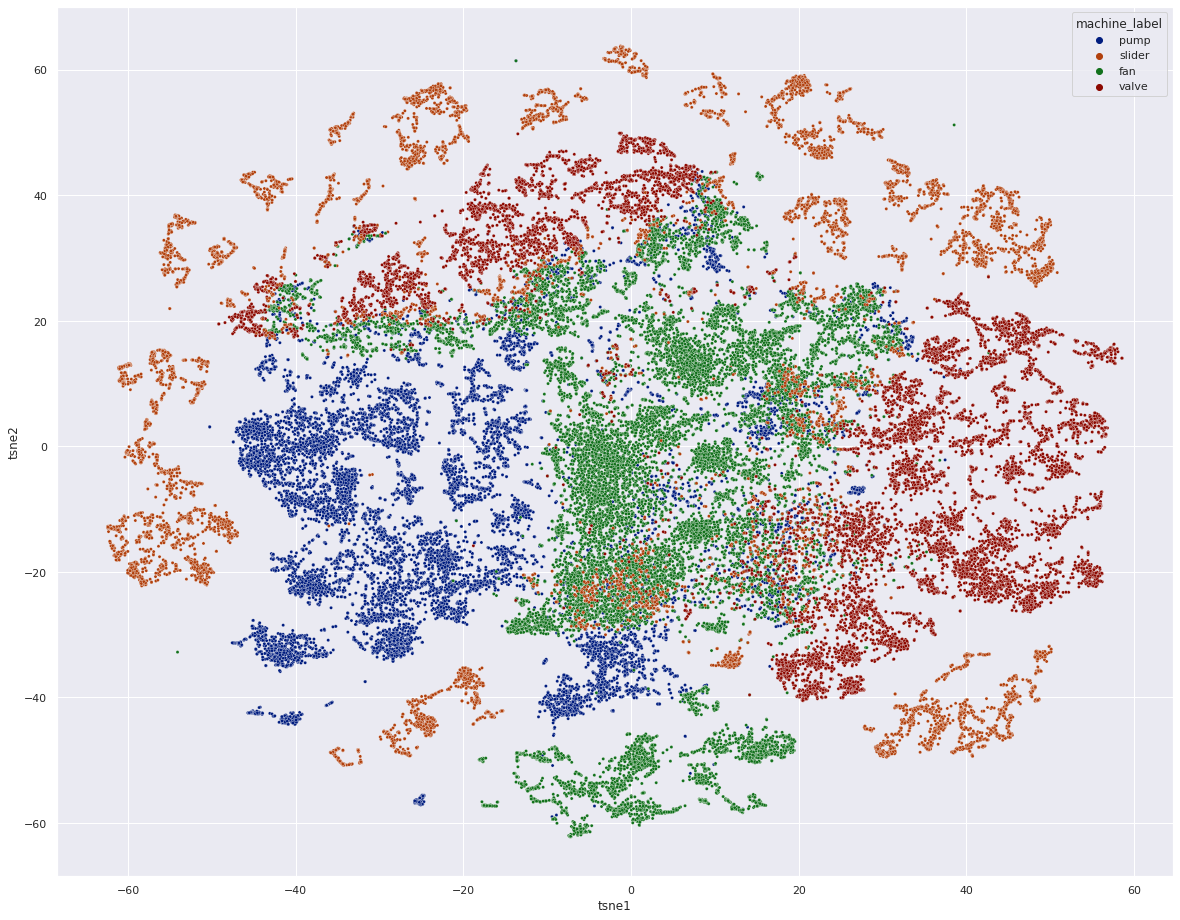

In [52]:
seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_results, x='tsne1', y='tsne2', hue='machine_label', palette="dark", s=10)

plt.show()

In [51]:
tsne_results['bin_label'] = train_all['operation_type']
tsne_results['machine_label'] = train_all['machine_type']

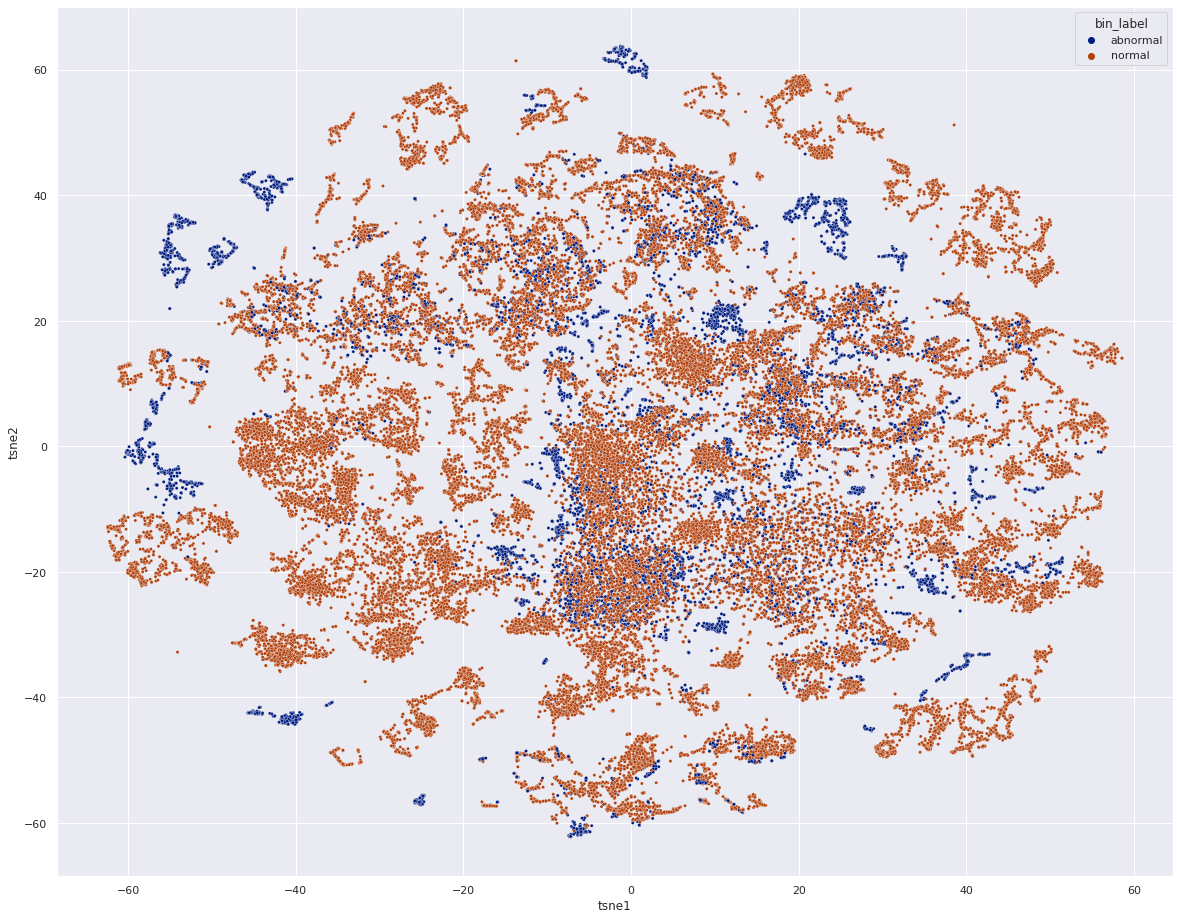

In [50]:
seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_results, x='tsne1', y='tsne2', hue='bin_label', palette="dark", s=10)

plt.show()

In [ ]:
tsne_pump = tsne_results[tsne_results["machine_label"] == 'pump']
tsne_slider = tsne_results[tsne_results["machine_label"] == 'slider']
tsne_valve = tsne_results[tsne_results["machine_label"] == 'valve']
tsne_fan = tsne_results[tsne_results["machine_label"] == 'fan']

f, ax = plt.subplots(2,2,figsize=(10, 10))
seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_pump, x='tsne1', y='tsne2', hue='bin_label', palette="dark", s=10, ax=ax[0][0]).set_title('pump')

#plt.show()

seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_slider, x='tsne1', y='tsne2', hue='bin_label', palette="dark", s=10, ax=ax[0][1]).set_title('slider')

#plt.show()

seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_valve, x='tsne1', y='tsne2', hue='bin_label', palette="dark", s=10, ax=ax[1][0]).set_title('valve')

#plt.show()

seaborn.set(rc={'figure.figsize':(20,16)})
seaborn.scatterplot(data=tsne_fan, x='tsne1', y='tsne2', hue='bin_label', palette="dark", s=10, ax=ax[1][1]).set_title('fan')

plt.show()